In [32]:
import os
import pydot
import graphviz
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from keras.layers import Convolution1D, MaxPooling1D, Flatten, Dense, Embedding, Activation, BatchNormalization,Dropout, GRU, Bidirectional

In [33]:
def ConvolutionalNet(vocabulary_size, embedding_dimension, input_length, embedding_weights=None):
    model = Sequential()
    if embedding_weights is None:
        model.add(Embedding(vocabulary_size, embedding_dimension, input_length=input_length, trainable=False))
    else:
        model.add(Embedding(vocabulary_size, embedding_dimension, input_length=input_length, weights=[embedding_weights], trainable=False))

    model.add(Dense(100, activation='relu'))  
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(128)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [34]:
SEQUENCE_LENGTH = 20
EMBEDDING_DIMENSION = 30

def words_to_indices(inverse_vocabulary, words):
    return [inverse_vocabulary[word] for word in words]

if __name__ == "__main__":

    vocabulary = open("../data/vocabulary.txt").read().split("\n")
    inverse_vocabulary = dict((word, i) for i, word in enumerate(vocabulary))

    clickbait = open("../data/clickbait.preprocessed.txt").read().split("\n")
    clickbait = pad_sequences([words_to_indices(inverse_vocabulary, sentence.split()) for sentence in clickbait], maxlen=SEQUENCE_LENGTH)

    genuine = open("../data/genuine.preprocessed.txt").read().split("\n")
    genuine = pad_sequences([words_to_indices(inverse_vocabulary, sentence.split()) for sentence in genuine], maxlen=SEQUENCE_LENGTH)

    X = np.concatenate([clickbait, genuine], axis=0)
    y = np.array([[1] * clickbait.shape[0] + [0] * genuine.shape[0]], dtype=np.int32).T
    p = np.random.permutation(y.shape[0])
    X = X[p]
    y = y[p]

    X_train, X_test, y_train, y_test =  train_test_split(X, y, stratify=y)

    embedding_weights = np.load("../models/embeddings.npy")
    params = dict(vocabulary_size=len(vocabulary), embedding_dimension=EMBEDDING_DIMENSION, input_length=SEQUENCE_LENGTH, embedding_weights=embedding_weights)
    model = ConvolutionalNet(**params)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=20, shuffle=True, callbacks=[EarlyStopping(monitor="val_loss", patience=2)])

Epoch 1/20
1025/1025 [==============================] - 52s 46ms/step - loss: 0.2694 - acc: 0.8948 - val_loss: 0.1954 - val_acc: 0.9241
Epoch 2/20
1025/1025 [==============================] - 44s 43ms/step - loss: 0.1896 - acc: 0.9285 - val_loss: 0.2017 - val_acc: 0.9218
Epoch 3/20
1025/1025 [==============================] - 46s 45ms/step - loss: 0.1683 - acc: 0.9373 - val_loss: 0.1505 - val_acc: 0.9437
Epoch 4/20
1025/1025 [==============================] - 46s 44ms/step - loss: 0.1504 - acc: 0.9453 - val_loss: 0.1462 - val_acc: 0.9446
Epoch 5/20
1025/1025 [==============================] - 45s 44ms/step - loss: 0.1324 - acc: 0.9512 - val_loss: 0.1343 - val_acc: 0.9508
Epoch 6/20
1025/1025 [==============================] - 44s 43ms/step - loss: 0.1190 - acc: 0.9570 - val_loss: 0.1351 - val_acc: 0.9512
Epoch 7/20
1025/1025 [==============================] - 44s 43ms/step - loss: 0.1080 - acc: 0.9607 - val_loss: 0.1470 - val_acc: 0.9528


In [35]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

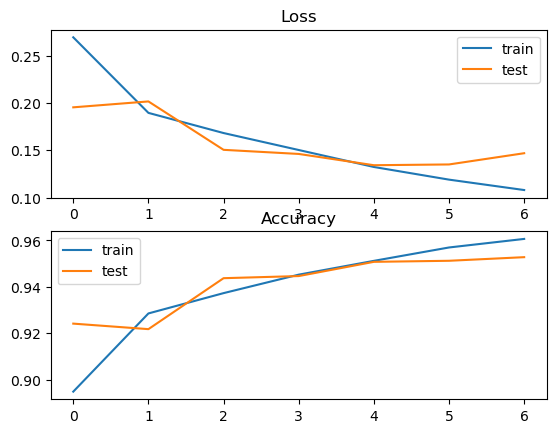

In [36]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [37]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 
def get_model(X_train, y_train):
 model = ConvolutionalNet(**params)
 model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
 model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=20, shuffle=True, callbacks=[EarlyStopping(monitor="val_loss", patience=2)])
 return model
 
model = get_model(X_train, y_train)
 
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Epoch 1/20
1025/1025 [==============================] - 28s 24ms/step - loss: 0.2658 - acc: 0.8980 - val_loss: 0.1951 - val_acc: 0.9255
Epoch 2/20
1025/1025 [==============================] - 26s 25ms/step - loss: 0.1905 - acc: 0.9267 - val_loss: 0.1631 - val_acc: 0.9358
Epoch 3/20
1025/1025 [==============================] - 28s 27ms/step - loss: 0.1648 - acc: 0.9400 - val_loss: 0.1626 - val_acc: 0.9428
Epoch 4/20
1025/1025 [==============================] - 29s 28ms/step - loss: 0.1471 - acc: 0.9453 - val_loss: 0.1452 - val_acc: 0.9489
Epoch 5/20
1025/1025 [==============================] - 29s 28ms/step - loss: 0.1312 - acc: 0.9519 - val_loss: 0.1325 - val_acc: 0.9544
Epoch 6/20
1025/1025 [==============================] - 30s 29ms/step - loss: 0.1233 - acc: 0.9546 - val_loss: 0.1325 - val_acc: 0.9523
Epoch 7/20
1025/1025 [==============================] - 32s 31ms/step - loss: 0.1082 - acc: 0.9609 - val_loss: 0.1362 - val_acc: 0.9539
Epoch 8/20
1025/1025 [==========================

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [29]:
print(len(yhat_probs))
print(len(yhat_classes))
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

10929
10929
Accuracy: 0.505078
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


C:\Users\abhin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
